# Hacktiv8 Data Science Talent Fair
### E-Commerce Costumer Behaviour Segmentation

Muhammad Farhan Zahirysah

---
### Description

these report is for pulling insight from the user events of an E-commerce and clustering the costumer using RFM and K-means Clustering

## Import Library

In [1]:
# essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from functools import reduce

# import scikit-learn libray
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
# removing warnings in cell
import warnings
warnings.filterwarnings('ignore')

In [2]:
print('Pandas Version     :',pd.__version__)
print('Numpy Version      :',np.__version__)
print('Matplotlib Version :',matplotlib.__version__)
print('Sklearn Version    :',sklearn.__version__)

Pandas Version     : 1.4.0
Numpy Version      : 1.21.5
Matplotlib Version : 3.5.1
Sklearn Version    : 1.0.2


## Load Data

In [3]:
df = pd.read_csv("first_question/user-events.csv")

In [4]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


creating category column that contain category id and catecory code

In [5]:
df_month = df.dropna(subset=['category_code', 'brand'])
df_month['category'] = df_month['category_id'].astype(str) + '_' + df_month['category_code']
df_month.nunique()

event_time       501225
event_type            3
product_id        24256
category_id         260
category_code       104
brand               728
price              9478
user_id          224996
user_session     273421
category            260
dtype: int64

looking for unique category inside event_type

In [6]:
pd.DataFrame(df_month['event_type'].value_counts())

,event_type
view,458572
cart,34671
purchase,23106


In [7]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516349 entries, 1 to 885128
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     516349 non-null  object 
 1   event_type     516349 non-null  object 
 2   product_id     516349 non-null  int64  
 3   category_id    516349 non-null  int64  
 4   category_code  516349 non-null  object 
 5   brand          516349 non-null  object 
 6   price          516349 non-null  float64
 7   user_id        516349 non-null  int64  
 8   user_session   516256 non-null  object 
 9   category       516349 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 43.3+ MB


In [8]:
df_month['price'].describe()

count    516349.000000
mean        188.922426
std         347.533955
min           0.900000
25%          45.240000
50%         105.870000
75%         249.380000
max       64771.060000
Name: price, dtype: float64

## Exploratory Data Analysis
---
before we are going to explore the data let me explain what im looking for in this dataset. this dataset is containing 6 month of user activity and is from ecommerce data from an online multi-category store. there will be four types of profiles:

- Overall Costumer profile : these profile will be generated the following columns
  - User count
  - View count
  - cart count
  - purchase count
  - session count
  - spent
  - min spent
  - max spent
  - median spent
  - average spent
  - min activity date
  - max activity date
  - min view date
  - max view date
  - min cart date
  - max cart date 
  - min purchase date
  - max purchase date


- Costumer Category Profile 
  - same as overall costumer profile but aggregating using user id and category


- Costumer Brand Profile 
  - same as overall costumer profile but aggegating using user id and brand


- Costumer Product Profile
  - same as overall costumer profile but aggregating using user id and product


after all that we are going to create costumer full profile by calculating the following:
- costomer retailer age from the first activity to last activity date
- days since last activity 
- first view age from first view to last view
- days since last view
- first adding to cart age from first add cart to last add cart date
- days since last cart
- first purchase age from first purchase to last purchase date
- days since last purchase

then we are going to separating the behavior of the user by the user only viewing and the user that actualy purchasing

### A. Creating User Profile by Month

first of all we are going to count each view, add to cart and purchase each user

In [9]:
df_month['event_date'] = df_month['event_time'].str[:10]
df_month['event_date'] = df_month['event_date'].astype('datetime64[ns]')
df_month.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,event_date
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY,2144415926932472027_computers.components.cooler,2020-09-24
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08,2144415923107266682_computers.peripherals.printer,2020-09-24
5,2020-09-24 11:57:59 UTC,view,664325,2144415951611757447,construction.tools.saw,carver,52.33,1515915625519388062,vnkdP81DDW,2144415951611757447_construction.tools.saw,2020-09-24
7,2020-09-24 11:58:24 UTC,view,716611,2144415923694469257,computers.network.router,d-link,53.14,1515915625519388882,kVBeYDPcBw,2144415923694469257_computers.network.router,2020-09-24
9,2020-09-24 11:58:31 UTC,view,716611,2144415923694469257,computers.network.router,d-link,53.14,1515915625519388929,F3VB9LYp39,2144415923694469257_computers.network.router,2020-09-24


making data frame table that grouping by user id and event type and then counting the size for view, cart and purchase

In [10]:
# Obtaining event counts by customer
customer_views = pd.DataFrame(df_month.loc[df_month['event_type'] == 'view'].groupby(['user_id', 'event_type']).size()).reset_index()
customer_views.columns = ['user_id','event_type','view_count'] # Renaming columns
customer_views = customer_views[['user_id','view_count']]# Keeping only wanted columns

customer_carts = pd.DataFrame(df_month.loc[df_month['event_type'] == 'cart'].groupby(['user_id', 'event_type']).size()).reset_index()
customer_carts.columns = ['user_id','event_type','cart_count']# Renaming columns
customer_carts = customer_carts[['user_id','cart_count']]# Keeping only wanted columns

customer_purchases = pd.DataFrame(df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id', 'event_type']).size()).reset_index()
customer_purchases.columns = ['user_id','event_type','purchase_count']# Renaming columns
customer_purchases = customer_purchases[['user_id','purchase_count']]# Keeping only wanted columns

# Merging event counts dfs together
data_frames = [customer_views, customer_carts, customer_purchases]
customer_profile = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],how='outer'), data_frames)
# Filling NaN values with 0
customer_profile[['view_count', 'cart_count', 'purchase_count']] = customer_profile[['view_count', 'cart_count', 'purchase_count']].fillna(value=0)
customer_profile.head()

,user_id,view_count,cart_count,purchase_count
0,1515915625353226922,1.0,0.0,0.0
1,1515915625353230683,13.0,0.0,0.0
2,1515915625353230922,1.0,0.0,0.0
3,1515915625353234047,35.0,0.0,0.0
4,1515915625353236157,1.0,0.0,0.0


then we can get user session count by grouping user id and user session

In [11]:
# Obtaining sessions by customer
customer_sessions = pd.DataFrame(df_month.groupby(['user_id', 'user_session']).size()).reset_index()
customer_sessions.columns = ['user_id','user_session','session_count']# Renaming columns
customer_sessions = customer_sessions[['user_id','session_count']]# Keeping only wanted columns

#Merging customer_sessions with customer_profile
customer_profile = pd.merge(customer_profile, customer_sessions, on=["user_id"], how='left')
# Filling NaN values with 0
customer_profile[['session_count']] = customer_profile[['session_count']].fillna(value=0)
customer_profile.head()

,user_id,view_count,cart_count,purchase_count,session_count
0,1515915625353226922,1.0,0.0,0.0,1.0
1,1515915625353230683,13.0,0.0,0.0,3.0
2,1515915625353230683,13.0,0.0,0.0,1.0
3,1515915625353230683,13.0,0.0,0.0,1.0
4,1515915625353230683,13.0,0.0,0.0,8.0


dropping duplicates of user id after we counting the session

In [12]:
# Dropping duplicates as we only want one row per each user_id
customer_profile = customer_profile.drop_duplicates(subset=['user_id'])
customer_profile.shape

(224996, 5)

getting spent per user by aggregating of sum by user id and price

In [13]:
# Obtaining spent by customer
customer_spent = pd.DataFrame(df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id'])['price'].agg('sum')).reset_index()
customer_spent.columns = ['user_id','spent']# Renaming columns

#Merging customer_spent with customer_profile
customer_profile = pd.merge(customer_profile, customer_spent, on=["user_id"], how='left')
# Filling NaN values with 0
customer_profile[['spent']] = customer_profile[['spent']].fillna(value=0)
customer_profile.head()

,user_id,view_count,cart_count,purchase_count,session_count,spent
0,1515915625353226922,1.0,0.0,0.0,1.0,0.0
1,1515915625353230683,13.0,0.0,0.0,3.0,0.0
2,1515915625353230922,1.0,0.0,0.0,1.0,0.0
3,1515915625353234047,35.0,0.0,0.0,35.0,0.0
4,1515915625353236157,1.0,0.0,0.0,1.0,0.0


getting max, min, median, and average spent by each user id

In [14]:
# Grabbing min and max spent a customer has
cust_spent = pd.DataFrame(df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id']).price.agg(min_spent=np.min, max_spent=np.max, median_spent=np.median, avg_spent=np.average).reset_index())
# Merging results
customer_profile = pd.merge(customer_profile, cust_spent, on=["user_id"], how='left')
# Filling NaN values with 0
customer_profile[['min_spent','max_spent','median_spent','avg_spent']] = customer_profile[['min_spent','max_spent','median_spent','avg_spent']].fillna(value=0)                          
customer_profile.head()

,user_id,view_count,cart_count,purchase_count,session_count,spent,min_spent,max_spent,median_spent,avg_spent
0,1515915625353226922,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1515915625353230683,13.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
2,1515915625353230922,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1515915625353234047,35.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0
4,1515915625353236157,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


obtaining minimum and maximum activity date from df_month

In [15]:
# Grabbing first and last date a customer did an event (any event)
cust_dates = df_month.groupby(['user_id']).event_date.agg(min_activity_date=np.min, max_activity_date=np.max).reset_index()
# Merging results
customer_profile = pd.merge(customer_profile, cust_dates, on=["user_id"], how='inner')
customer_profile.head()

,user_id,view_count,cart_count,purchase_count,session_count,spent,min_spent,max_spent,median_spent,avg_spent,min_activity_date,max_activity_date
0,1515915625353226922,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-29,2020-10-29
1,1515915625353230683,13.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-12-12
2,1515915625353230922,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-02,2020-10-02
3,1515915625353234047,35.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,2020-09-29,2021-02-18
4,1515915625353236157,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2021-02-11,2021-02-11


obtaining minumum and maximum for view, cart, purchase on each user id

In [16]:
# Grabbing first and last date by event for each customer
cust_dates_view = df_month.loc[df_month['event_type'] == 'view'].groupby(['user_id']).event_date.agg(min_view_date=np.min, max_view_date=np.max).reset_index()
cust_dates_cart = df_month.loc[df_month['event_type'] == 'cart'].groupby(['user_id']).event_date.agg(min_cart_date=np.min, max_cart_date=np.max).reset_index()
cust_dates_purchase = df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id']).event_date.agg(min_purchase_date=np.min, max_purchase_date=np.max).reset_index()

#Merging dfs together
data_frames = [customer_profile,cust_dates_view, cust_dates_cart, cust_dates_purchase]
customer_profile = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],how='outer'), data_frames)
customer_profile.head()

,user_id,view_count,cart_count,purchase_count,session_count,spent,min_spent,max_spent,median_spent,avg_spent,min_activity_date,max_activity_date,min_view_date,max_view_date,min_cart_date,max_cart_date,min_purchase_date,max_purchase_date
0,1515915625353226922,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-29,2020-10-29,2020-10-29,2020-10-29,NaT,NaT,NaT,NaT
1,1515915625353230683,13.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-12-12,2020-11-09,2020-12-12,NaT,NaT,NaT,NaT
2,1515915625353230922,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-02,2020-10-02,2020-10-02,2020-10-02,NaT,NaT,NaT,NaT
3,1515915625353234047,35.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,2020-09-29,2021-02-18,2020-09-29,2021-02-18,NaT,NaT,NaT,NaT
4,1515915625353236157,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2021-02-11,2021-02-11,2021-02-11,2021-02-11,NaT,NaT,NaT,NaT


adding month for getting the last time the user have been in the online ecommerce

In [17]:
# Adding month columns
customer_profile['month'] = customer_profile['max_activity_date'].dt.to_period('M')
customer_profile.head()

,user_id,view_count,cart_count,purchase_count,session_count,spent,min_spent,max_spent,median_spent,avg_spent,min_activity_date,max_activity_date,min_view_date,max_view_date,min_cart_date,max_cart_date,min_purchase_date,max_purchase_date,month
0,1515915625353226922,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-29,2020-10-29,2020-10-29,2020-10-29,NaT,NaT,NaT,NaT,2020-10
1,1515915625353230683,13.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-12-12,2020-11-09,2020-12-12,NaT,NaT,NaT,NaT,2020-12
2,1515915625353230922,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-02,2020-10-02,2020-10-02,2020-10-02,NaT,NaT,NaT,NaT,2020-10
3,1515915625353234047,35.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,2020-09-29,2021-02-18,2020-09-29,2021-02-18,NaT,NaT,NaT,NaT,2021-02
4,1515915625353236157,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2021-02-11,2021-02-11,2021-02-11,2021-02-11,NaT,NaT,NaT,NaT,2021-02


saving the query dataframe into csv file

In [18]:
customer_profile.to_csv("EDA/customer_profile.csv",index=False)

### Creating Costumer Category Profile

first of all we are going to count each view, add to cart and purchase each user and category of the product

In [19]:
# Obtaining event counts by customer and category
customer_views = pd.DataFrame(df_month.loc[df_month['event_type'] == 'view'].groupby(['user_id','category','event_type']).size()).reset_index()
customer_views.columns = ['user_id','category','event_type','view_count']# Renaming columns
customer_views = customer_views[['user_id','category','view_count']]# Keeping only wanted columns

customer_carts = pd.DataFrame(df_month.loc[df_month['event_type'] == 'cart'].groupby(['user_id','category', 'event_type']).size()).reset_index()
customer_carts.columns = ['user_id','category','event_type','cart_count']# Renaming columns
customer_carts = customer_carts[['user_id','category','cart_count']]# Keeping only wanted columns

customer_purchases = pd.DataFrame(df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id','category', 'event_type']).size()).reset_index()
customer_purchases.columns = ['user_id','category','event_type','purchase_count']# Renaming columns
customer_purchases = customer_purchases[['user_id','category','purchase_count']]# Keeping only wanted columns

# Merging event counts dfs together
data_frames = [customer_views, customer_carts, customer_purchases]
customer_profile = reduce(lambda  left,right: pd.merge(left,right,on=['user_id','category'],how='outer'), data_frames)
# Filling NaN values with 0
customer_profile[['view_count', 'cart_count', 'purchase_count']] = customer_profile[['view_count', 'cart_count', 'purchase_count']].fillna(value=0)
customer_profile.head()

,user_id,category,view_count,cart_count,purchase_count
0,1515915625353226922,2144415939364389423_electronics.clocks,1.0,0.0,0.0
1,1515915625353230683,2144415923107266682_computers.peripherals.printer,1.0,0.0,0.0
2,1515915625353230683,2144415924424278172_electronics.audio.acoustic,12.0,0.0,0.0
3,1515915625353230922,2144415922427789416_computers.components.video...,1.0,0.0,0.0
4,1515915625353234047,2144415924684325027_electronics.audio.headphone,19.0,0.0,0.0


adding user sesssion and grouping by user and category of products

In [20]:
# Obtaining sessions by customer and category
customer_sessions = pd.DataFrame(df_month.groupby(['user_id','category', 'user_session']).size()).reset_index()
customer_sessions.columns = ['user_id','category','user_session','session_count']# Renaming columns
customer_sessions = customer_sessions[['user_id','category','session_count']]# Keeping only wanted columns

#Merging customer_sessions with customer_profile
customer_profile = pd.merge(customer_profile, customer_sessions, on=["user_id","category"], how='left')
# Filling NaN values with 0
customer_profile[['session_count']] = customer_profile[['session_count']].fillna(value=0)
customer_profile.head()

,user_id,category,view_count,cart_count,purchase_count,session_count
0,1515915625353226922,2144415939364389423_electronics.clocks,1.0,0.0,0.0,1.0
1,1515915625353230683,2144415923107266682_computers.peripherals.printer,1.0,0.0,0.0,1.0
2,1515915625353230683,2144415924424278172_electronics.audio.acoustic,12.0,0.0,0.0,3.0
3,1515915625353230683,2144415924424278172_electronics.audio.acoustic,12.0,0.0,0.0,1.0
4,1515915625353230683,2144415924424278172_electronics.audio.acoustic,12.0,0.0,0.0,8.0


dropping user duplicate after we obtaining session count

In [ ]:
customer_profile = customer_profile.drop_duplicates(subset=['user_id','category'])

adding sum of spent for each user and category that the user spend on

In [21]:
# Obtaining spent by customer/category combination
customer_spent = pd.DataFrame(df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id','category'])['price'].agg('sum')).reset_index()
customer_spent.columns = ['user_id','category','spent']# Renaming columns

#Merging customer_spent with customer_profile
customer_profile = pd.merge(customer_profile, customer_spent, on=["user_id","category"], how='left')
# Filling NaN values with 0
customer_profile[['spent']] = customer_profile[['spent']].fillna(value=0)
customer_profile.head()

,user_id,category,view_count,cart_count,purchase_count,session_count,spent
0,1515915625353226922,2144415939364389423_electronics.clocks,1.0,0.0,0.0,1.0,0.0
1,1515915625353230683,2144415923107266682_computers.peripherals.printer,1.0,0.0,0.0,1.0,0.0
2,1515915625353230683,2144415924424278172_electronics.audio.acoustic,12.0,0.0,0.0,3.0,0.0
3,1515915625353230922,2144415922427789416_computers.components.video...,1.0,0.0,0.0,1.0,0.0
4,1515915625353234047,2144415924684325027_electronics.audio.headphone,19.0,0.0,0.0,19.0,0.0


adding min, median, max, average for spending on each user id and category

In [22]:
# Grabbing min and max spent a customer has per category
cust_spent = pd.DataFrame(df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id','category']).price.agg(min_category_spent=np.min, max_category_spent=np.max, median_category_spent=np.median, avg_category_spent=np.average).reset_index())
# Merging results
customer_profile = pd.merge(customer_profile, cust_spent, on=["user_id","category"], how='left')
# Filling NaN values with 0
customer_profile[['min_category_spent','max_category_spent','median_category_spent','avg_category_spent']] = customer_profile[['min_category_spent','max_category_spent','median_category_spent','avg_category_spent']].fillna(value=0)                          
customer_profile.head()

,user_id,category,view_count,cart_count,purchase_count,session_count,spent,min_category_spent,max_category_spent,median_category_spent,avg_category_spent
0,1515915625353226922,2144415939364389423_electronics.clocks,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1515915625353230683,2144415923107266682_computers.peripherals.printer,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1515915625353230683,2144415924424278172_electronics.audio.acoustic,12.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
3,1515915625353230922,2144415922427789416_computers.components.video...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1515915625353234047,2144415924684325027_electronics.audio.headphone,19.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0


adding minimum and maximum activity date from df_month for each user id and category grouping

In [23]:
# Grabbing first and last date a customer did an event (any event) for a specific category
cust_dates = df_month.groupby(['user_id','category']).event_date.agg(min_activity_date=np.min, max_activity_date=np.max).reset_index()
# Merging results
customer_profile = pd.merge(customer_profile, cust_dates, on=["user_id","category"], how='inner')
customer_profile.head()

,user_id,category,view_count,cart_count,purchase_count,session_count,spent,min_category_spent,max_category_spent,median_category_spent,avg_category_spent,min_activity_date,max_activity_date
0,1515915625353226922,2144415939364389423_electronics.clocks,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-29,2020-10-29
1,1515915625353230683,2144415923107266682_computers.peripherals.printer,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-12-12,2020-12-12
2,1515915625353230683,2144415924424278172_electronics.audio.acoustic,12.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-18
3,1515915625353230922,2144415922427789416_computers.components.video...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-02,2020-10-02
4,1515915625353234047,2144415924684325027_electronics.audio.headphone,19.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,2020-10-10,2021-02-18


grabbing first date and last date for view, cart and purchase date.

In [24]:
# Grabbing first and last date by event for each customer/category
cust_dates_view = df_month.loc[df_month['event_type'] == 'view'].groupby(['user_id','category']).event_date.agg(min_view_date=np.min, max_view_date=np.max).reset_index()
cust_dates_cart = df_month.loc[df_month['event_type'] == 'cart'].groupby(['user_id','category']).event_date.agg(min_cart_date=np.min, max_cart_date=np.max).reset_index()
cust_dates_purchase = df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id','category']).event_date.agg(min_purchase_date=np.min, max_purchase_date=np.max).reset_index()

#Merging dfs together
data_frames = [customer_profile,cust_dates_view, cust_dates_cart, cust_dates_purchase]
customer_profile = reduce(lambda  left,right: pd.merge(left,right,on=['user_id','category'],how='outer'), data_frames)
customer_profile.head()

,user_id,category,view_count,cart_count,purchase_count,session_count,spent,min_category_spent,max_category_spent,median_category_spent,avg_category_spent,min_activity_date,max_activity_date,min_view_date,max_view_date,min_cart_date,max_cart_date,min_purchase_date,max_purchase_date
0,1515915625353226922,2144415939364389423_electronics.clocks,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-29,2020-10-29,2020-10-29,2020-10-29,NaT,NaT,NaT,NaT
1,1515915625353230683,2144415923107266682_computers.peripherals.printer,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-12-12,2020-12-12,2020-12-12,2020-12-12,NaT,NaT,NaT,NaT
2,1515915625353230683,2144415924424278172_electronics.audio.acoustic,12.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-18,2020-11-09,2020-11-18,NaT,NaT,NaT,NaT
3,1515915625353230922,2144415922427789416_computers.components.video...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-02,2020-10-02,2020-10-02,2020-10-02,NaT,NaT,NaT,NaT
4,1515915625353234047,2144415924684325027_electronics.audio.headphone,19.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,2020-10-10,2021-02-18,2020-10-10,2021-02-18,NaT,NaT,NaT,NaT


adding month columns from the last time the user having activity in the online ecommerce

In [25]:
# Adding month columns
customer_profile['month'] = customer_profile['max_activity_date'].dt.to_period('M')
customer_profile.head()
# Dropping duplicates as we only want one row per distinct user_id/category
customer_profile = customer_profile.drop_duplicates(subset=['user_id','category'])
customer_profile.head()

,user_id,category,view_count,cart_count,purchase_count,session_count,spent,min_category_spent,max_category_spent,median_category_spent,avg_category_spent,min_activity_date,max_activity_date,min_view_date,max_view_date,min_cart_date,max_cart_date,min_purchase_date,max_purchase_date,month
0,1515915625353226922,2144415939364389423_electronics.clocks,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-29,2020-10-29,2020-10-29,2020-10-29,NaT,NaT,NaT,NaT,2020-10
1,1515915625353230683,2144415923107266682_computers.peripherals.printer,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-12-12,2020-12-12,2020-12-12,2020-12-12,NaT,NaT,NaT,NaT,2020-12
2,1515915625353230683,2144415924424278172_electronics.audio.acoustic,12.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-18,2020-11-09,2020-11-18,NaT,NaT,NaT,NaT,2020-11
3,1515915625353230922,2144415922427789416_computers.components.video...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-02,2020-10-02,2020-10-02,2020-10-02,NaT,NaT,NaT,NaT,2020-10
4,1515915625353234047,2144415924684325027_electronics.audio.headphone,19.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,2020-10-10,2021-02-18,2020-10-10,2021-02-18,NaT,NaT,NaT,NaT,2021-02


saving the query of costumer category profile to csv

In [26]:
customer_profile.to_csv("EDA/customer_category_profile.csv",index=False)

### Creating Costumer Brand Profile

as simple as before we are going to creating dataframe table. the difference is we are going to adding brand instead of category. 

now we are counting view, cart, purchase by user id and brand

In [27]:
# Obtaining event counts by customer and brand
customer_views = pd.DataFrame(df_month.loc[df_month['event_type'] == 'view'].groupby(['user_id','brand','event_type']).size()).reset_index()
customer_views.columns = ['user_id','brand','event_type','view_count']# Renaming columns
customer_views = customer_views[['user_id','brand','view_count']]# Keeping only wanted columns

customer_carts = pd.DataFrame(df_month.loc[df_month['event_type'] == 'cart'].groupby(['user_id','brand', 'event_type']).size()).reset_index()
customer_carts.columns = ['user_id','brand','event_type','cart_count']# Renaming columns
customer_carts = customer_carts[['user_id','brand','cart_count']]# Keeping only wanted columns

customer_purchases = pd.DataFrame(df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id','brand', 'event_type']).size()).reset_index()
customer_purchases.columns = ['user_id','brand','event_type','purchase_count']# Renaming columns
customer_purchases = customer_purchases[['user_id','brand','purchase_count']]# Keeping only wanted columns

# Merging event counts dfs together
data_frames = [customer_views, customer_carts, customer_purchases]
customer_profile = reduce(lambda  left,right: pd.merge(left,right,on=['user_id','brand'],how='outer'), data_frames)
# Filling NaN values with 0
customer_profile[['view_count', 'cart_count', 'purchase_count']] = customer_profile[['view_count', 'cart_count', 'purchase_count']].fillna(value=0)
customer_profile.head()

,user_id,brand,view_count,cart_count,purchase_count
0,1515915625353226922,honor,1.0,0.0,0.0
1,1515915625353230683,bbk,1.0,0.0,0.0
2,1515915625353230683,canon,1.0,0.0,0.0
3,1515915625353230683,canyon,1.0,0.0,0.0
4,1515915625353230683,creative,4.0,0.0,0.0


making session columns from grouping by user id and brand

In [28]:
# Obtaining sessions by customer and brand
customer_sessions = pd.DataFrame(df_month.groupby(['user_id','brand', 'user_session']).size()).reset_index()
customer_sessions.columns = ['user_id','brand','user_session','session_count']# Renaming columns
customer_sessions = customer_sessions[['user_id','brand','session_count']]# Keeping only wanted columns

#Merging customer_sessions with customer_profile
customer_profile = pd.merge(customer_profile, customer_sessions, on=["user_id","brand"], how='left')
# Filling NaN values with 0
customer_profile[['session_count']] = customer_profile[['session_count']].fillna(value=0)
customer_profile.head()

,user_id,brand,view_count,cart_count,purchase_count,session_count
0,1515915625353226922,honor,1.0,0.0,0.0,1.0
1,1515915625353230683,bbk,1.0,0.0,0.0,1.0
2,1515915625353230683,canon,1.0,0.0,0.0,1.0
3,1515915625353230683,canyon,1.0,0.0,0.0,1.0
4,1515915625353230683,creative,4.0,0.0,0.0,3.0


dropping duplicates after we adding session count

In [ ]:
customer_profile = customer_profile.drop_duplicates(subset=['user_id','brand'])

obtaining total spent for each user and brand by aggregating sum of price

In [29]:
# Obtaining spent by customer/brand combination
customer_spent = pd.DataFrame(df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id','brand'])['price'].agg('sum')).reset_index()
customer_spent.columns = ['user_id','brand','spent']# Renaming columns

#Merging customer_spent with customer_profile
customer_profile = pd.merge(customer_profile, customer_spent, on=["user_id","brand"], how='left')
# Filling NaN values with 0
customer_profile[['spent']] = customer_profile[['spent']].fillna(value=0)
customer_profile.head()

,user_id,brand,view_count,cart_count,purchase_count,session_count,spent
0,1515915625353226922,honor,1.0,0.0,0.0,1.0,0.0
1,1515915625353230683,bbk,1.0,0.0,0.0,1.0,0.0
2,1515915625353230683,canon,1.0,0.0,0.0,1.0,0.0
3,1515915625353230683,canyon,1.0,0.0,0.0,1.0,0.0
4,1515915625353230683,creative,4.0,0.0,0.0,3.0,0.0


adding min, max, median, average from spent grouping by user id and brand

In [30]:
# Grabbing min and max spent a customer has per brand
cust_spent = pd.DataFrame(df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id','brand']).price.agg(min_brand_spent=np.min, max_brand_spent=np.max, median_brand_spent=np.median, avg_brand_spent=np.average).reset_index())
# Merging results
customer_profile = pd.merge(customer_profile, cust_spent, on=["user_id","brand"], how='left')
# Filling NaN values with 0
customer_profile[['min_brand_spent','max_brand_spent','median_brand_spent','avg_brand_spent']] = customer_profile[['min_brand_spent','max_brand_spent','median_brand_spent','avg_brand_spent']].fillna(value=0)                          
customer_profile.head()

,user_id,brand,view_count,cart_count,purchase_count,session_count,spent,min_brand_spent,max_brand_spent,median_brand_spent,avg_brand_spent
0,1515915625353226922,honor,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1515915625353230683,bbk,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1515915625353230683,canon,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1515915625353230683,canyon,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1515915625353230683,creative,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


getting first and last date for each user and brand event

In [31]:
# Grabbing first and last date a customer did an event (any event) for a specific brand
cust_dates = df_month.groupby(['user_id','brand']).event_date.agg(min_activity_date=np.min, max_activity_date=np.max).reset_index()
# Merging results
customer_profile = pd.merge(customer_profile, cust_dates, on=["user_id","brand"], how='inner')
customer_profile.head()

,user_id,brand,view_count,cart_count,purchase_count,session_count,spent,min_brand_spent,max_brand_spent,median_brand_spent,avg_brand_spent,min_activity_date,max_activity_date
0,1515915625353226922,honor,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-29,2020-10-29
1,1515915625353230683,bbk,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09
2,1515915625353230683,canon,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-12-12,2020-12-12
3,1515915625353230683,canyon,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09
4,1515915625353230683,creative,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2020-11-18,2020-11-18


grabbing the first and last date by view,cart, and purchase for each user id and brand

In [32]:
# Grabbing first and last date by event for each customer/brand
cust_dates_view = df_month.loc[df_month['event_type'] == 'view'].groupby(['user_id','brand']).event_date.agg(min_view_date=np.min, max_view_date=np.max).reset_index()
cust_dates_cart = df_month.loc[df_month['event_type'] == 'cart'].groupby(['user_id','brand']).event_date.agg(min_cart_date=np.min, max_cart_date=np.max).reset_index()
cust_dates_purchase = df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id','brand']).event_date.agg(min_purchase_date=np.min, max_purchase_date=np.max).reset_index()

#Merging dfs together
data_frames = [customer_profile,cust_dates_view, cust_dates_cart, cust_dates_purchase]
customer_profile = reduce(lambda  left,right: pd.merge(left,right,on=['user_id','brand'],how='outer'), data_frames)
customer_profile.head()

,user_id,brand,view_count,cart_count,purchase_count,session_count,spent,min_brand_spent,max_brand_spent,median_brand_spent,avg_brand_spent,min_activity_date,max_activity_date,min_view_date,max_view_date,min_cart_date,max_cart_date,min_purchase_date,max_purchase_date
0,1515915625353226922,honor,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-29,2020-10-29,2020-10-29,2020-10-29,NaT,NaT,NaT,NaT
1,1515915625353230683,bbk,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09,2020-11-09,2020-11-09,NaT,NaT,NaT,NaT
2,1515915625353230683,canon,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-12-12,2020-12-12,2020-12-12,2020-12-12,NaT,NaT,NaT,NaT
3,1515915625353230683,canyon,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09,2020-11-09,2020-11-09,NaT,NaT,NaT,NaT
4,1515915625353230683,creative,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2020-11-18,2020-11-18,2020-11-18,2020-11-18,NaT,NaT,NaT,NaT


adding the last time in month the costumer making activity in the online ecommerce

In [33]:
# Adding month columns
customer_profile['month'] = customer_profile['max_activity_date'].dt.to_period('M')
# Dropping duplicates as we only want one row per distinct user_id/brand
customer_profile = customer_profile.drop_duplicates(subset=['user_id','brand'])
customer_profile.head()

,user_id,brand,view_count,cart_count,purchase_count,session_count,spent,min_brand_spent,max_brand_spent,median_brand_spent,avg_brand_spent,min_activity_date,max_activity_date,min_view_date,max_view_date,min_cart_date,max_cart_date,min_purchase_date,max_purchase_date,month
0,1515915625353226922,honor,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-29,2020-10-29,2020-10-29,2020-10-29,NaT,NaT,NaT,NaT,2020-10
1,1515915625353230683,bbk,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09,2020-11-09,2020-11-09,NaT,NaT,NaT,NaT,2020-11
2,1515915625353230683,canon,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-12-12,2020-12-12,2020-12-12,2020-12-12,NaT,NaT,NaT,NaT,2020-12
3,1515915625353230683,canyon,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09,2020-11-09,2020-11-09,NaT,NaT,NaT,NaT,2020-11
4,1515915625353230683,creative,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2020-11-18,2020-11-18,2020-11-18,2020-11-18,NaT,NaT,NaT,NaT,2020-11


saving the query into costumer brand profile into csv

In [34]:
customer_profile.to_csv("EDA/customer_brand_profile.csv",index=False)

### Creating Costumer Product Profile

before we proceed the usual steps we are going to merge product id and category code, these one is used for knowing what is in product id by looking also in category code.

In [35]:
# Creating product column that will also contain the category to make it more meaningful when looking at it
df_month['product'] = df_month['product_id'].astype(str) + '_' + df_month['category_code']
df_month.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,event_date,product
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY,2144415926932472027_computers.components.cooler,2020-09-24,139905_computers.components.cooler
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08,2144415923107266682_computers.peripherals.printer,2020-09-24,635807_computers.peripherals.printer
5,2020-09-24 11:57:59 UTC,view,664325,2144415951611757447,construction.tools.saw,carver,52.33,1515915625519388062,vnkdP81DDW,2144415951611757447_construction.tools.saw,2020-09-24,664325_construction.tools.saw
7,2020-09-24 11:58:24 UTC,view,716611,2144415923694469257,computers.network.router,d-link,53.14,1515915625519388882,kVBeYDPcBw,2144415923694469257_computers.network.router,2020-09-24,716611_computers.network.router
9,2020-09-24 11:58:31 UTC,view,716611,2144415923694469257,computers.network.router,d-link,53.14,1515915625519388929,F3VB9LYp39,2144415923694469257_computers.network.router,2020-09-24,716611_computers.network.router


as usual we are going to count view, cart and purchase by grouping user id and product

In [36]:
# Obtaining event counts by customer and product
customer_views = pd.DataFrame(df_month.loc[df_month['event_type'] == 'view'].groupby(['user_id','product','event_type']).size()).reset_index()
customer_views.columns = ['user_id','product','event_type','view_count']# Renaming columns
customer_views = customer_views[['user_id','product','view_count']]# Keeping only wanted columns

customer_carts = pd.DataFrame(df_month.loc[df_month['event_type'] == 'cart'].groupby(['user_id','product', 'event_type']).size()).reset_index()
customer_carts.columns = ['user_id','product','event_type','cart_count']# Renaming columns
customer_carts = customer_carts[['user_id','product','cart_count']]# Keeping only wanted columns

customer_purchases = pd.DataFrame(df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id','product', 'event_type']).size()).reset_index()
customer_purchases.columns = ['user_id','product','event_type','purchase_count']# Renaming columns
customer_purchases = customer_purchases[['user_id','product','purchase_count']]# Keeping only wanted columns

# Merging event counts dfs together
data_frames = [customer_views, customer_carts, customer_purchases]
customer_profile = reduce(lambda  left,right: pd.merge(left,right,on=['user_id','product'],how='outer'), data_frames)
# Filling NaN values with 0
customer_profile[['view_count', 'cart_count', 'purchase_count']] = customer_profile[['view_count', 'cart_count', 'purchase_count']].fillna(value=0)
customer_profile.head()

,user_id,product,view_count,cart_count,purchase_count
0,1515915625353226922,4101974_electronics.clocks,1.0,0.0,0.0
1,1515915625353230683,1038457_electronics.audio.acoustic,1.0,0.0,0.0
2,1515915625353230683,124883_electronics.audio.acoustic,1.0,0.0,0.0
3,1515915625353230683,125325_electronics.audio.acoustic,1.0,0.0,0.0
4,1515915625353230683,1399881_electronics.audio.acoustic,1.0,0.0,0.0


obtaining session by costumer and product

In [37]:
# Obtaining sessions by customer and product
customer_sessions = pd.DataFrame(df_month.groupby(['user_id','product', 'user_session']).size()).reset_index()
customer_sessions.columns = ['user_id','product','user_session','session_count']# Renaming columns
customer_sessions = customer_sessions[['user_id','product','session_count']]# Keeping only wanted columns

#Merging customer_sessions with customer_profile
customer_profile = pd.merge(customer_profile, customer_sessions, on=["user_id","product"], how='left')
# Filling NaN values with 0
customer_profile[['session_count']] = customer_profile[['session_count']].fillna(value=0)
customer_profile.head()

,user_id,product,view_count,cart_count,purchase_count,session_count
0,1515915625353226922,4101974_electronics.clocks,1.0,0.0,0.0,1.0
1,1515915625353230683,1038457_electronics.audio.acoustic,1.0,0.0,0.0,1.0
2,1515915625353230683,124883_electronics.audio.acoustic,1.0,0.0,0.0,1.0
3,1515915625353230683,125325_electronics.audio.acoustic,1.0,0.0,0.0,1.0
4,1515915625353230683,1399881_electronics.audio.acoustic,1.0,0.0,0.0,1.0


dropping user id and product duplicate after we obtaining session count

In [ ]:
# Dropping duplicates as we only want one row per distinct user_id/product
customer_profile = customer_profile.drop_duplicates(subset=['user_id','product'])

creating total spent by aggregating of sum price for each user and product

In [38]:
# Obtaining spent by customer/product combination
customer_spent = pd.DataFrame(df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id','product'])['price'].agg('sum')).reset_index()
customer_spent.columns = ['user_id','product','spent']# Renaming columns

#Merging customer_spent with customer_profile
customer_profile = pd.merge(customer_profile, customer_spent, on=["user_id","product"], how='left')
# Filling NaN values with 0
customer_profile[['spent']] = customer_profile[['spent']].fillna(value=0)
customer_profile.head()

,user_id,product,view_count,cart_count,purchase_count,session_count,spent
0,1515915625353226922,4101974_electronics.clocks,1.0,0.0,0.0,1.0,0.0
1,1515915625353230683,1038457_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0
2,1515915625353230683,124883_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0
3,1515915625353230683,125325_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0
4,1515915625353230683,1399881_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0


grabbing min, max, median, average of spent by each product and user id

In [39]:
# Grabbing min and max spent a customer has per product
cust_spent = pd.DataFrame(df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id','product']).price.agg(min_product_spent=np.min, max_product_spent=np.max, median_product_spent=np.median, avg_product_spent=np.average).reset_index())
# Merging results
customer_profile = pd.merge(customer_profile, cust_spent, on=["user_id","product"], how='left')
# Filling NaN values with 0
customer_profile[['min_product_spent','max_product_spent','median_product_spent','avg_product_spent']] = customer_profile[['min_product_spent','max_product_spent','median_product_spent','avg_product_spent']].fillna(value=0)                          
customer_profile.head()

,user_id,product,view_count,cart_count,purchase_count,session_count,spent,min_product_spent,max_product_spent,median_product_spent,avg_product_spent
0,1515915625353226922,4101974_electronics.clocks,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1515915625353230683,1038457_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1515915625353230683,124883_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1515915625353230683,125325_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1515915625353230683,1399881_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


grabbing first and last date from the activity grouping by user id and product

In [40]:
# Grabbing first and last date a customer did an event (any event) for a specific product
cust_dates = df_month.groupby(['user_id','product']).event_date.agg(min_activity_date=np.min, max_activity_date=np.max).reset_index()
# Merging results
customer_profile = pd.merge(customer_profile, cust_dates, on=["user_id","product"], how='inner')
customer_profile.head()

,user_id,product,view_count,cart_count,purchase_count,session_count,spent,min_product_spent,max_product_spent,median_product_spent,avg_product_spent,min_activity_date,max_activity_date
0,1515915625353226922,4101974_electronics.clocks,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-29,2020-10-29
1,1515915625353230683,1038457_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09
2,1515915625353230683,124883_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09
3,1515915625353230683,125325_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09
4,1515915625353230683,1399881_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09


grabbing first adna last date by view, cart, and purchase for each costumer and product

In [41]:
# Grabbing first and last date by event for each customer/product
cust_dates_view = df_month.loc[df_month['event_type'] == 'view'].groupby(['user_id','product']).event_date.agg(min_view_date=np.min, max_view_date=np.max).reset_index()
cust_dates_cart = df_month.loc[df_month['event_type'] == 'cart'].groupby(['user_id','product']).event_date.agg(min_cart_date=np.min, max_cart_date=np.max).reset_index()
cust_dates_purchase = df_month.loc[df_month['event_type'] == 'purchase'].groupby(['user_id','product']).event_date.agg(min_purchase_date=np.min, max_purchase_date=np.max).reset_index()

#Merging dfs together
data_frames = [customer_profile,cust_dates_view, cust_dates_cart, cust_dates_purchase]
customer_profile = reduce(lambda  left,right: pd.merge(left,right,on=['user_id','product'],how='outer'), data_frames)
customer_profile.head()

,user_id,product,view_count,cart_count,purchase_count,session_count,spent,min_product_spent,max_product_spent,median_product_spent,avg_product_spent,min_activity_date,max_activity_date,min_view_date,max_view_date,min_cart_date,max_cart_date,min_purchase_date,max_purchase_date
0,1515915625353226922,4101974_electronics.clocks,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-29,2020-10-29,2020-10-29,2020-10-29,NaT,NaT,NaT,NaT
1,1515915625353230683,1038457_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09,2020-11-09,2020-11-09,NaT,NaT,NaT,NaT
2,1515915625353230683,124883_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09,2020-11-09,2020-11-09,NaT,NaT,NaT,NaT
3,1515915625353230683,125325_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09,2020-11-09,2020-11-09,NaT,NaT,NaT,NaT
4,1515915625353230683,1399881_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09,2020-11-09,2020-11-09,NaT,NaT,NaT,NaT


adding last month the user has activity in the online ecommerce

In [42]:
# Adding month columns
customer_profile['month'] = customer_profile['max_activity_date'].dt.to_period('M')
customer_profile.head()
# Dropping duplicates as we only want one row per distinct user_id/product
customer_profile = customer_profile.drop_duplicates(subset=['user_id','product'])
customer_profile.head()

,user_id,product,view_count,cart_count,purchase_count,session_count,spent,min_product_spent,max_product_spent,median_product_spent,avg_product_spent,min_activity_date,max_activity_date,min_view_date,max_view_date,min_cart_date,max_cart_date,min_purchase_date,max_purchase_date,month
0,1515915625353226922,4101974_electronics.clocks,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-10-29,2020-10-29,2020-10-29,2020-10-29,NaT,NaT,NaT,NaT,2020-10
1,1515915625353230683,1038457_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09,2020-11-09,2020-11-09,NaT,NaT,NaT,NaT,2020-11
2,1515915625353230683,124883_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09,2020-11-09,2020-11-09,NaT,NaT,NaT,NaT,2020-11
3,1515915625353230683,125325_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09,2020-11-09,2020-11-09,NaT,NaT,NaT,NaT,2020-11
4,1515915625353230683,1399881_electronics.audio.acoustic,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-11-09,2020-11-09,2020-11-09,2020-11-09,NaT,NaT,NaT,NaT,2020-11


saving the query costumer product profile into csv

In [43]:
customer_profile.to_csv("EDA/customer_product_profile.csv",index=False)

### Creating Full Customer Profile

full costumer profile is adding the calculation from date to date, we are going to create the following columns:
- costomer retailer age from the first activity to last activity date
- days since last activity 
- first view age from first view to last view
- days since last view
- first adding to cart age from first add cart to last add cart date
- days since last cart
- first purchase age from first purchase to last purchase date
- days since last purchase

In [96]:
cust_profile = pd.read_csv("EDA/customer_profile.csv")

viewing costumer profile

In [97]:
cust_profile.head()

,user_id,view_count,cart_count,purchase_count,session_count,spent,min_spent,max_spent,median_spent,avg_spent,min_activity_date,max_activity_date,min_view_date,max_view_date,min_cart_date,max_cart_date,min_purchase_date,max_purchase_date,month
0,1515915625353226922,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,2020-10-29,2020-10-29,2020-10-29,2020-10-29,NaN,NaN,NaN,NaN,2020-10
1,1515915625353230683,13.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,2020-11-09,2020-12-12,2020-11-09,2020-12-12,NaN,NaN,NaN,NaN,2020-12
2,1515915625353230922,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,2020-10-02,2020-10-02,2020-10-02,2020-10-02,NaN,NaN,NaN,NaN,2020-10
3,1515915625353234047,35.00,0.00,0.00,35.00,0.00,0.00,0.00,0.00,0.00,2020-09-29,2021-02-18,2020-09-29,2021-02-18,NaN,NaN,NaN,NaN,2021-02
4,1515915625353236157,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,2021-02-11,2021-02-11,2021-02-11,2021-02-11,NaN,NaN,NaN,NaN,2021-02


creating ranking. since the most new date in the dataset is february 2021 then the month is going to be rank 1 and dropping below when getting older until october 2020

In [98]:
cust_profile.loc[(cust_profile['month'] == '2020-9'),'month_rank'] = 6
cust_profile.loc[(cust_profile['month'] == '2020-10'),'month_rank'] = 5
cust_profile.loc[(cust_profile['month'] == '2020-11'),'month_rank'] = 4
cust_profile.loc[(cust_profile['month'] == '2020-12'),'month_rank'] = 3
cust_profile.loc[(cust_profile['month'] == '2021-01'),'month_rank'] = 2
cust_profile.loc[(cust_profile['month'] == '2021-02'),'month_rank'] = 1

making sure that each date columns are datetime type

In [100]:
# Transforming date columns to datetime type
cust_profile["max_activity_date"] = cust_profile["max_activity_date"].astype('datetime64[ns]')
cust_profile["min_activity_date"] = cust_profile["min_activity_date"].astype('datetime64[ns]')

cust_profile["min_view_date"] = cust_profile["min_view_date"].astype('datetime64[ns]')
cust_profile["max_view_date"] = cust_profile["max_view_date"].astype('datetime64[ns]')

cust_profile["min_cart_date"] = cust_profile["min_cart_date"].astype('datetime64[ns]')
cust_profile["max_cart_date"] = cust_profile["max_cart_date"].astype('datetime64[ns]')

cust_profile["max_purchase_date"] = cust_profile["max_purchase_date"].astype('datetime64[ns]')
cust_profile["min_purchase_date"] = cust_profile["min_purchase_date"].astype('datetime64[ns]')

grabbing maximum activity, view, cart, purchase date for each user id

In [101]:
# Grabbing max dates based on month rank
max_activity_dates = cust_profile.sort_values('max_activity_date',ascending = False).groupby('user_id').head(1)
max_activity_dates = max_activity_dates[['user_id','max_activity_date']]

max_view_dates = cust_profile.sort_values('max_view_date',ascending = False).groupby('user_id').head(1)
max_view_dates = max_view_dates[['user_id','max_view_date']]

max_cart_dates = cust_profile.sort_values('max_cart_date',ascending = False).groupby('user_id').head(1)
max_cart_dates = max_cart_dates[['user_id','max_cart_date']]

max_purchase_dates = cust_profile.sort_values('max_purchase_date',ascending = False).groupby('user_id').head(1)
max_purchase_dates = max_purchase_dates[['user_id','max_purchase_date']]

# merging_max_dates
data_frames = [max_activity_dates,max_view_dates, max_cart_dates, max_purchase_dates]
max_dates = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],how='outer'), data_frames)
max_dates.head()

,user_id,max_activity_date,max_view_date,max_cart_date,max_purchase_date
0,1515915625610826820,2021-02-28,2021-02-28,NaT,NaT
1,1515915625610782350,2021-02-28,2021-02-28,2021-02-28,NaT
2,1515915625610775564,2021-02-28,2021-02-28,2021-02-28,NaT
3,1515915625610775983,2021-02-28,2021-02-28,2021-02-28,2021-02-28
4,1515915625610776059,2021-02-28,2021-02-28,NaT,NaT


grabbing minimum activity, view, cart, and purchase for each user id

In [102]:
# Grabbing min dates based on month rank
min_activity_dates = cust_profile.sort_values('min_activity_date',ascending = True).groupby('user_id').head(1)
min_activity_dates = min_activity_dates[['user_id','min_activity_date']]

min_view_dates = cust_profile.sort_values('min_view_date',ascending = True).groupby('user_id').head(1)
min_view_dates = min_view_dates[['user_id','min_view_date']]

min_cart_dates = cust_profile.sort_values('min_cart_date',ascending = True).groupby('user_id').head(1)
min_cart_dates = min_cart_dates[['user_id','min_cart_date']]

min_purchase_dates = cust_profile.sort_values('min_purchase_date',ascending = True).groupby('user_id').head(1)
min_purchase_dates = min_purchase_dates[['user_id','min_purchase_date']]

# merging_min_dates
data_frames = [min_activity_dates,min_view_dates, min_cart_dates, min_purchase_dates]
min_dates = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],how='outer'), data_frames)
min_dates.head()

,user_id,min_activity_date,min_view_date,min_cart_date,min_purchase_date
0,1515915625519464736,2020-09-24,2020-09-24,NaT,NaT
1,1515915625519477101,2020-09-24,2020-09-24,NaT,NaT
2,1515915625519477104,2020-09-24,2020-09-24,NaT,NaT
3,1515915625519477135,2020-09-24,2020-09-24,NaT,NaT
4,1515915625519477241,2020-09-24,2020-09-24,2020-09-24,2020-09-24


merging the max and minimum calculation also defining max possible date from data

In [103]:
# Obtaining max possible date from data 
column = cust_profile["max_activity_date"].astype('datetime64[ns]')
max_date = column.max() 
# Transforming date columns to datetime format
max_dates[['max_activity_date','max_view_date','max_cart_date', 'max_purchase_date']] = max_dates[['max_activity_date','max_view_date','max_cart_date', 'max_purchase_date']].astype('datetime64[ns]')
min_dates[['min_activity_date','min_view_date','min_cart_date', 'min_purchase_date']] = min_dates[['min_activity_date','min_view_date','min_cart_date', 'min_purchase_date']].astype('datetime64[ns]')

customer_dates = pd.merge(max_dates, min_dates, on=["user_id"], how='inner')
customer_dates.head()

,user_id,max_activity_date,max_view_date,max_cart_date,max_purchase_date,min_activity_date,min_view_date,min_cart_date,min_purchase_date
0,1515915625610826820,2021-02-28,2021-02-28,NaT,NaT,2021-02-28,2021-02-28,NaT,NaT
1,1515915625610782350,2021-02-28,2021-02-28,2021-02-28,NaT,2021-02-28,2021-02-28,2021-02-28,NaT
2,1515915625610775564,2021-02-28,2021-02-28,2021-02-28,NaT,2021-02-28,2021-02-28,2021-02-28,NaT
3,1515915625610775983,2021-02-28,2021-02-28,2021-02-28,2021-02-28,2021-02-28,2021-02-28,2021-02-28,2021-02-28
4,1515915625610776059,2021-02-28,2021-02-28,NaT,NaT,2021-02-28,2021-02-28,NaT,NaT


calculating days for activity, view, cart, and purchase age and days since the last time to the maximum date in the dataset

In [104]:
# Calculating days since each event and customer activity
customer_dates['cust_retailer_age'] = (max_date - customer_dates['min_activity_date']).dt.days
customer_dates['days_since_last_activity'] = (max_date - customer_dates['max_activity_date']).dt.days

customer_dates['first_view_age'] = (max_date - customer_dates['min_view_date']).dt.days
customer_dates['days_since_last_view'] = (max_date - customer_dates['max_view_date']).dt.days

customer_dates['first_cart_age'] = (max_date - customer_dates['min_cart_date']).dt.days
customer_dates['days_since_last_cart'] = (max_date - customer_dates['max_cart_date']).dt.days


customer_dates['first_purchase_age'] = (max_date - customer_dates['min_purchase_date']).dt.days
customer_dates['days_since_last_purchase'] = (max_date - customer_dates['max_purchase_date']).dt.days

customer_dates[['cust_retailer_age',
       'days_since_last_activity', 'first_view_age', 'days_since_last_view',
       'first_cart_age', 'days_since_last_cart', 'first_purchase_age',
       'days_since_last_purchase']] = customer_dates[['cust_retailer_age',
       'days_since_last_activity', 'first_view_age', 'days_since_last_view',
       'first_cart_age', 'days_since_last_cart', 'first_purchase_age',
       'days_since_last_purchase']].fillna(value=9999)# Replacing nan with 9999 to symbolize they have not done said action

customer_dates.head()

,user_id,max_activity_date,max_view_date,max_cart_date,max_purchase_date,min_activity_date,min_view_date,min_cart_date,min_purchase_date,cust_retailer_age,days_since_last_activity,first_view_age,days_since_last_view,first_cart_age,days_since_last_cart,first_purchase_age,days_since_last_purchase
0,1515915625610826820,2021-02-28,2021-02-28,NaT,NaT,2021-02-28,2021-02-28,NaT,NaT,0,0,0.00,0.00,9999.00,9999.00,9999.00,9999.00
1,1515915625610782350,2021-02-28,2021-02-28,2021-02-28,NaT,2021-02-28,2021-02-28,2021-02-28,NaT,0,0,0.00,0.00,0.00,0.00,9999.00,9999.00
2,1515915625610775564,2021-02-28,2021-02-28,2021-02-28,NaT,2021-02-28,2021-02-28,2021-02-28,NaT,0,0,0.00,0.00,0.00,0.00,9999.00,9999.00
3,1515915625610775983,2021-02-28,2021-02-28,2021-02-28,2021-02-28,2021-02-28,2021-02-28,2021-02-28,2021-02-28,0,0,0.00,0.00,0.00,0.00,0.00,0.00
4,1515915625610776059,2021-02-28,2021-02-28,NaT,NaT,2021-02-28,2021-02-28,NaT,NaT,0,0,0.00,0.00,9999.00,9999.00,9999.00,9999.00


grabbing minimum and maximum spent

In [105]:
# Grabbing min and max spent
max_spent = cust_profile.groupby(['user_id']).max_spent.agg(max_spent=np.max).reset_index()
min_spent = cust_profile.groupby(['user_id']).min_spent.agg(min_spent=np.min).reset_index()

customer_spent = pd.merge(min_spent, max_spent, on=["user_id"], how='inner')
customer_spent.head()

,user_id,min_spent,max_spent
0,1515915625353226922,0.00,0.00
1,1515915625353230683,0.00,0.00
2,1515915625353230922,0.00,0.00
3,1515915625353234047,0.00,0.00
4,1515915625353236157,0.00,0.00


merging the date calculation dataframe and spent 

In [106]:
# Merging spent and date dfs
customer_agg = pd.merge(customer_spent, customer_dates[['user_id','cust_retailer_age',
       'days_since_last_activity', 'first_view_age', 'days_since_last_view',
       'first_cart_age', 'days_since_last_cart', 'first_purchase_age',
       'days_since_last_purchase']], on=["user_id"], how='inner')
customer_agg.nunique()

user_id                     224996
min_spent                     2141
max_spent                     2132
cust_retailer_age              158
days_since_last_activity       158
first_view_age                 159
days_since_last_view           159
first_cart_age                 159
days_since_last_cart           159
first_purchase_age             159
days_since_last_purchase       159
dtype: int64

aggregating sum numeric columns for view, cart, purchase, session and spent columns 

In [107]:
# Aggregating numeric columns from cust_profile
customer_views = pd.DataFrame(cust_profile.groupby(['user_id'])['view_count'].agg('sum')).reset_index()
customer_views.columns = ['user_id','total_view']# Renaming columns
customer_carts = pd.DataFrame(cust_profile.groupby(['user_id'])['cart_count'].agg('sum')).reset_index()
customer_carts.columns = ['user_id','total_cart_add']# Renaming columns
customer_purchases = pd.DataFrame(cust_profile.groupby(['user_id'])['purchase_count'].agg('sum')).reset_index()
customer_purchases.columns = ['user_id','total_purchases']# Renaming columns
customer_sessions = pd.DataFrame(cust_profile.groupby(['user_id'])['session_count'].agg('sum')).reset_index()
customer_sessions.columns = ['user_id','total_sessions']# Renaming columns
customer_spent = pd.DataFrame(cust_profile.groupby(['user_id'])['spent'].agg('sum')).reset_index()
customer_spent.columns = ['user_id','total_spent']# Renaming columns

# Merging event counts dfs together
data_frames = [customer_views, customer_carts, customer_purchases, customer_sessions, customer_spent]
customer_profile = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],how='outer'), data_frames)
customer_profile.nunique()

user_id            224996
total_view            128
total_cart_add         36
total_purchases        30
total_sessions         96
total_spent          4548
dtype: int64

merging the aggregation before into costumer profile

In [108]:
customer_profile = pd.merge(customer_profile, customer_agg, on=["user_id"], how='inner')
customer_profile.head()

,user_id,total_view,total_cart_add,total_purchases,total_sessions,total_spent,min_spent,max_spent,cust_retailer_age,days_since_last_activity,first_view_age,days_since_last_view,first_cart_age,days_since_last_cart,first_purchase_age,days_since_last_purchase
0,1515915625353226922,1.00,0.00,0.00,1.00,0.00,0.00,0.00,122,122,122.00,122.00,9999.00,9999.00,9999.00,9999.00
1,1515915625353230683,13.00,0.00,0.00,3.00,0.00,0.00,0.00,111,78,111.00,78.00,9999.00,9999.00,9999.00,9999.00
2,1515915625353230922,1.00,0.00,0.00,1.00,0.00,0.00,0.00,149,149,149.00,149.00,9999.00,9999.00,9999.00,9999.00
3,1515915625353234047,35.00,0.00,0.00,35.00,0.00,0.00,0.00,152,10,152.00,10.00,9999.00,9999.00,9999.00,9999.00
4,1515915625353236157,1.00,0.00,0.00,1.00,0.00,0.00,0.00,17,17,17.00,17.00,9999.00,9999.00,9999.00,9999.00


In [109]:
customer_profile.nunique()

user_id                     224996
total_view                     128
total_cart_add                  36
total_purchases                 30
total_sessions                  96
total_spent                   4548
min_spent                     2141
max_spent                     2132
cust_retailer_age              158
days_since_last_activity       158
first_view_age                 159
days_since_last_view           159
first_cart_age                 159
days_since_last_cart           159
first_purchase_age             159
days_since_last_purchase       159
dtype: int64

saving the table costumer profile full into csv

In [110]:
customer_profile.to_csv("EDA/customer_profile_full.csv",index=False)

### Creating Customer Behavior

then we are going to separating the behavior of the user by the user only viewing and the user that actualy purchasing

In [116]:
customer_profile = pd.read_csv("EDA/customer_profile_full.csv")

viewing the details of profile full data

In [152]:
customer_profile.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,224996.00,1515915625558516480.00,33668709.02,1515915625353227008.00,1515915625533054720.00,1515915625551649280.00,1515915625594670848.00,1515915625611024128.00
total_view,224996.00,2.04,4.21,0.00,1.00,1.00,2.00,572.00
total_cart_add,224996.00,0.15,0.72,0.00,0.00,0.00,0.00,68.00
total_purchases,224996.00,0.10,0.58,0.00,0.00,0.00,0.00,56.00
total_sessions,224996.00,1.77,3.04,0.00,1.00,1.00,2.00,572.00
total_spent,224996.00,18.39,138.00,0.00,0.00,0.00,0.00,12080.83
min_spent,224996.00,10.23,61.76,0.00,0.00,0.00,0.00,3717.65
max_spent,224996.00,10.91,65.95,0.00,0.00,0.00,0.00,3717.65
cust_retailer_age,224996.00,78.59,45.17,0.00,39.00,80.00,117.00,157.00
days_since_last_activity,224996.00,77.38,45.29,0.00,37.00,79.00,116.00,157.00


now we are finding the user that never spend in the ecommerce

In [118]:
none_purchase_custs = customer_profile.loc[(customer_profile['total_spent'] == 0)]
none_purchase_custs.nunique()

user_id                     211955
total_view                     106
total_cart_add                  25
total_purchases                  1
total_sessions                  77
total_spent                      1
min_spent                        1
max_spent                        1
cust_retailer_age              158
days_since_last_activity       158
first_view_age                 158
days_since_last_view           158
first_cart_age                 159
days_since_last_cart           159
first_purchase_age               1
days_since_last_purchase         1
dtype: int64

In [119]:
none_purchase_custs.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,211955.00,1515915625560256000.00,33566724.27,1515915625353227008.00,1515915625532774400.00,1515915625550122496.00,1515915625594568448.00,1515915625611024128.00
total_view,211955.00,1.80,3.43,1.00,1.00,1.00,2.00,572.00
total_cart_add,211955.00,0.07,0.44,0.00,0.00,0.00,0.00,67.00
total_purchases,211955.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
total_sessions,211955.00,1.55,2.51,0.00,1.00,1.00,1.00,572.00
total_spent,211955.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min_spent,211955.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max_spent,211955.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
cust_retailer_age,211955.00,78.88,45.17,0.00,39.00,81.00,117.50,157.00
days_since_last_activity,211955.00,77.86,45.25,0.00,38.00,80.00,117.00,157.00


In [120]:
print(f"costumer only visits or add to chart but not buying : {none_purchase_custs['user_id'].count() / df_month['user_id'].nunique() *100:.2f} %")

costumer only visits or add to chart but not buying : 94.20 %


that conclude 94.2 % of customer are not spending any money in the ecommerce. these type customer are not valuable to calculating the segmentation

then we are going to find the customer that buying something in the ecommerce

In [121]:
purchase_custs = customer_profile.loc[(customer_profile['total_spent'] > 0)]
purchase_custs.nunique()

user_id                     13041
total_view                    105
total_cart_add                 32
total_purchases                29
total_sessions                 79
total_spent                  4547
min_spent                    2140
max_spent                    2131
cust_retailer_age             158
days_since_last_activity      158
first_view_age                159
days_since_last_view          159
first_cart_age                159
days_since_last_cart          159
first_purchase_age            158
days_since_last_purchase      158
dtype: int64

In [122]:
purchase_custs.describe()

,user_id,total_view,total_cart_add,total_purchases,total_sessions,total_spent,min_spent,max_spent,cust_retailer_age,days_since_last_activity,first_view_age,days_since_last_view,first_cart_age,days_since_last_cart,first_purchase_age,days_since_last_purchase
count,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00
mean,1515915625562445056.00,5.87,1.59,1.77,5.31,317.33,176.53,188.23,73.80,69.67,248.72,244.61,607.02,605.73,72.30,71.49
std,35011165.65,9.91,1.89,1.70,6.65,483.45,190.93,204.14,44.93,45.21,1307.24,1307.80,2240.70,2241.01,44.92,44.99
min,1515915625353286144.00,0.00,0.00,1.00,1.00,0.90,0.90,0.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1515915625536021248.00,2.00,1.00,1.00,3.00,57.13,43.11,43.11,35.00,30.00,36.00,31.00,36.00,34.00,34.00,33.00
50%,1515915625564021504.00,3.00,1.00,1.00,4.00,169.87,113.38,122.86,71.00,66.00,72.00,67.00,74.00,72.00,69.00,68.00
75%,1515915625595795968.00,6.00,2.00,2.00,6.00,405.34,251.40,268.17,112.00,108.00,114.00,110.00,117.00,116.00,110.00,110.00
max,1515915625610999552.00,303.00,68.00,56.00,197.00,12080.83,3717.65,3717.65,157.00,157.00,9999.00,9999.00,9999.00,9999.00,157.00,157.00


In [123]:
print(f"costumer actually buying : {purchase_custs['user_id'].count() / df_month['user_id'].nunique() *100:.2f} %")


costumer actually buying : 5.80 %


that conclude theres only 5.8% of user that actually buying product in the ecommerce

then we are going to save it into the costumer profile focus that we are going to segment

In [156]:
purchase_custs.to_csv('EDA/customer_profile_focus.csv',index=False)

## Segmenting Using RFM

viewing the focus dataset

In [157]:
main_custs = pd.read_csv("EDA/customer_profile_focus.csv")
main_custs.head().T

,0,1,2,3,4
user_id,1515915625353286144.00,1515915625353457152.00,1515915625353534720.00,1515915625353561600.00,1515915625353900032.00
total_view,8.00,1.00,5.00,6.00,36.00
total_cart_add,2.00,1.00,2.00,2.00,2.00
total_purchases,1.00,1.00,3.00,2.00,2.00
total_sessions,1.00,3.00,10.00,1.00,17.00
total_spent,119.03,55.16,57.15,345.72,57.85
min_spent,119.03,55.16,19.05,172.86,18.10
max_spent,119.03,55.16,19.05,172.86,39.75
cust_retailer_age,148.00,152.00,145.00,96.00,154.00
days_since_last_activity,128.00,152.00,136.00,95.00,133.00


viewing details in the data focus

In [158]:
pd.options.display.float_format = '{:.2f}'.format
main_custs.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,13041.00,1515915625562445056.00,35011165.65,1515915625353286144.00,1515915625536021248.00,1515915625564021504.00,1515915625595795968.00,1515915625610999552.00
total_view,13041.00,5.87,9.91,0.00,2.00,3.00,6.00,303.00
total_cart_add,13041.00,1.59,1.89,0.00,1.00,1.00,2.00,68.00
total_purchases,13041.00,1.77,1.70,1.00,1.00,1.00,2.00,56.00
total_sessions,13041.00,5.31,6.65,1.00,3.00,4.00,6.00,197.00
total_spent,13041.00,317.33,483.45,0.90,57.13,169.87,405.34,12080.83
min_spent,13041.00,176.53,190.93,0.90,43.11,113.38,251.40,3717.65
max_spent,13041.00,188.23,204.14,0.90,43.11,122.86,268.17,3717.65
cust_retailer_age,13041.00,73.80,44.93,0.00,35.00,71.00,112.00,157.00
days_since_last_activity,13041.00,69.67,45.21,0.00,30.00,66.00,108.00,157.00


RFM stands for
- Recency : Days since last purchase
- Frequency : Total Puchase the costumer has
- Monetary Value : Total costumer spent

because the columns are available from previous calculation. we are only need for selecting columns for RFM analysis

In [159]:
# Creating RFM DF
rfm_df = main_custs[['user_id','days_since_last_purchase','total_purchases','total_spent']]# Keeping needed columns for RFM
rfm_df.columns = ['user_id','R','F','M']# renaming the columns
rfm_df.head()

,user_id,R,F,M
0,1515915625353286099,148.00,1.00,119.03
1,1515915625353457259,152.00,1.00,55.16
2,1515915625353534622,145.00,3.00,57.15
3,1515915625353561691,95.00,2.00,345.72
4,1515915625353900095,136.00,2.00,57.85


viewing details of RFM table

In [160]:
rfm_df.describe()

,user_id,R,F,M
count,13041.00,13041.00,13041.00,13041.00
mean,1515915625562445056.00,71.49,1.77,317.33
std,35011165.65,44.99,1.70,483.45
min,1515915625353286144.00,0.00,1.00,0.90
25%,1515915625536021248.00,33.00,1.00,57.13
50%,1515915625564021504.00,68.00,1.00,169.87
75%,1515915625595795968.00,110.00,2.00,405.34
max,1515915625610999552.00,157.00,56.00,12080.83


now we are going to create RFM Score using quantile distribution

In [161]:
# Creating RFM Scores based on Quantile distribution
Q = rfm_df.quantile(q=[0.25,0.5,0.75])
Q = Q.to_dict()

# Recency Score will be calculated inversely from Frequency and Monetary Values
# The lower the recency the higher the score should be 
def R_Score(x,p,d):
    if x >= d[p][0.25]:
        return 1
    elif x >= d[p][0.50]:
        return 2
    elif x >= d[p][0.75]: 
        return 3
    else:
        return 4
    
# The higher the Frequency and Monetary Values the higher the score should be
def FM_Score(x,p,d):
    if x >= d[p][0.25]:
        return 4
    elif x >= d[p][0.50]:
        return 3
    elif x >= d[p][0.75]: 
        return 2
    else:
        return 1
    

# Creating RFM quantile columns
rfm_df['R_quantile_score'] = rfm_df['R'].apply(R_Score, args=('R',Q,))
rfm_df['F_quantile_score'] = rfm_df['F'].apply(FM_Score, args=('F',Q,))
rfm_df['M_quantile_score'] = rfm_df['M'].apply(FM_Score, args=('M',Q,))

# RFM Score column creation
rfm_df['RFM_Score'] = rfm_df['R_quantile_score'] + rfm_df['F_quantile_score'] + rfm_df['M_quantile_score']

rfm_df.head()

,user_id,R,F,M,R_quantile_score,F_quantile_score,M_quantile_score,RFM_Score
0,1515915625353286099,148.00,1.00,119.03,1,4,4,9
1,1515915625353457259,152.00,1.00,55.16,1,4,1,6
2,1515915625353534622,145.00,3.00,57.15,1,4,4,9
3,1515915625353561691,95.00,2.00,345.72,1,4,4,9
4,1515915625353900095,136.00,2.00,57.85,1,4,4,9


now we are obtaining the RFM score. the next step is creating costumer segment based of RFM values

In [162]:
rfm_df.describe()

,user_id,R,F,M,R_quantile_score,F_quantile_score,M_quantile_score,RFM_Score
count,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00,13041.00
mean,1515915625562445056.00,71.49,1.77,317.33,1.74,4.00,3.25,8.99
std,35011165.65,44.99,1.70,483.45,1.30,0.00,1.30,1.92
min,1515915625353286144.00,0.00,1.00,0.90,1.00,4.00,1.00,6.00
25%,1515915625536021248.00,33.00,1.00,57.13,1.00,4.00,4.00,9.00
50%,1515915625564021504.00,68.00,1.00,169.87,1.00,4.00,4.00,9.00
75%,1515915625595795968.00,110.00,2.00,405.34,1.00,4.00,4.00,9.00
max,1515915625610999552.00,157.00,56.00,12080.83,4.00,4.00,4.00,12.00


In [163]:
# Creating customer segment based on RFM values
rfm_df.loc[(rfm_df['RFM_Score'] == 12),'user_segment'] = 'Top_Customer'
rfm_df.loc[(rfm_df['RFM_Score'] == 11),'user_segment'] = 'High_Value_Customer'
rfm_df.loc[(rfm_df['RFM_Score'] <= rfm_df['RFM_Score'].quantile(.75)),'user_segment'] = 'High_Value_Customer'
rfm_df.loc[(rfm_df['RFM_Score'] <= rfm_df['RFM_Score'].quantile(.50)),'user_segment'] = 'Mid_Value_Customer'
rfm_df.loc[(rfm_df['RFM_Score'] <= rfm_df['RFM_Score'].quantile(.25)),'user_segment'] = 'Low_Value_Customer'
rfm_df.head()

,user_id,R,F,M,R_quantile_score,F_quantile_score,M_quantile_score,RFM_Score,user_segment
0,1515915625353286099,148.00,1.00,119.03,1,4,4,9,Low_Value_Customer
1,1515915625353457259,152.00,1.00,55.16,1,4,1,6,Low_Value_Customer
2,1515915625353534622,145.00,3.00,57.15,1,4,4,9,Low_Value_Customer
3,1515915625353561691,95.00,2.00,345.72,1,4,4,9,Low_Value_Customer
4,1515915625353900095,136.00,2.00,57.85,1,4,4,9,Low_Value_Customer


In [164]:
rfm_df['user_segment'].value_counts()

Low_Value_Customer    10376
Top_Customer           2665
Name: user_segment, dtype: int64

there are only 2 segment in the customer segmentation using RFM. low value costumer and top value costumer

In [165]:
rfm_df.to_csv("rfm_segmentation.csv",index=False)

## Segmenting Using Custering Model K-Means

In [166]:
cust_profile = pd.read_csv('EDA/customer_profile_focus.csv')

using data from costumer profile focus and total purchase above 1 therefore the model will not be imbalanced because there soo much costumer that only buying once

In [167]:
cust_profile = cust_profile.loc[cust_profile['total_purchases'] > 1]
cust_profile.nunique()

user_id                     4828
total_view                    97
total_cart_add                32
total_purchases               28
total_sessions                74
total_spent                 2899
min_spent                   1317
max_spent                   1288
cust_retailer_age            158
days_since_last_activity     158
first_view_age               159
days_since_last_view         159
first_cart_age               159
days_since_last_cart         159
first_purchase_age           158
days_since_last_purchase     158
dtype: int64

viewing details of costumer profile

In [168]:
pd.options.display.float_format = '{:.2f}'.format
cust_profile.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,4828.00,1515915625561509888.00,35789984.26,1515915625353534720.00,1515915625536007424.00,1515915625563443712.00,1515915625595142656.00,1515915625610999552.00
total_view,4828.00,8.68,12.71,0.00,3.00,5.00,10.00,225.00
total_cart_add,4828.00,2.32,2.77,0.00,1.00,2.00,3.00,68.00
total_purchases,4828.00,3.08,2.26,2.00,2.00,2.00,3.00,56.00
total_sessions,4828.00,7.13,8.90,1.00,3.00,5.00,8.00,197.00
total_spent,4828.00,543.19,692.39,2.47,115.24,331.88,742.92,12080.83
min_spent,4828.00,162.87,164.91,0.90,43.11,105.87,214.10,1800.35
max_spent,4828.00,194.47,203.79,0.90,48.81,126.68,284.30,3094.60
cust_retailer_age,4828.00,74.16,44.42,0.00,37.00,71.00,112.00,157.00
days_since_last_activity,4828.00,67.87,44.74,0.00,29.00,63.00,107.00,157.00


droping user id and unnamed, preparing for machine learning modeling

In [170]:
df_profile = cust_profile.drop(['user_id'],axis=1)
df_profile.head()

,total_view,total_cart_add,total_purchases,total_sessions,total_spent,min_spent,max_spent,cust_retailer_age,days_since_last_activity,first_view_age,days_since_last_view,first_cart_age,days_since_last_cart,first_purchase_age,days_since_last_purchase
2,5.00,2.00,3.00,10.00,57.15,19.05,19.05,145,136,145.00,136.00,145.00,145.00,145.00,145.00
3,6.00,2.00,2.00,1.00,345.72,172.86,172.86,96,95,96.00,95.00,96.00,95.00,96.00,95.00
4,36.00,2.00,2.00,17.00,57.85,18.10,39.75,154,133,154.00,133.00,136.00,136.00,136.00,136.00
6,15.00,3.00,3.00,2.00,155.04,51.68,51.68,156,149,156.00,149.00,156.00,149.00,156.00,149.00
8,13.00,2.00,2.00,1.00,210.28,105.14,105.14,103,101,103.00,101.00,103.00,101.00,101.00,101.00


creating data inference for testing into a new data

In [171]:
df_inf = df_profile.sample(10, random_state=1)

droping data inference from dataset

In [172]:
df_profile = df_profile.drop(index=df_inf.index)
cust_profile_drop = cust_profile.drop(index=df_inf.index)

scaling using standard scaler and normalize

In [173]:
# Since we have variables of multiple scales we will standardize the data before clustering
scaler = StandardScaler()
profile_scaled = scaler.fit_transform(df_profile)
# Rescailing standardize values into 0 to 1 scale
df_norm = normalize(df_profile)
df_norm = pd.DataFrame(df_norm)# converting results to df
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.01,0.00,0.01,0.02,0.14,0.05,0.05,0.35,0.33,0.35,0.33,0.35,0.35,0.35,0.35
1,0.01,0.00,0.00,0.00,0.69,0.34,0.34,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
2,0.09,0.00,0.00,0.04,0.14,0.04,0.10,0.38,0.33,0.38,0.33,0.34,0.34,0.34,0.34
3,0.03,0.01,0.01,0.00,0.33,0.11,0.11,0.34,0.32,0.34,0.32,0.34,0.32,0.34,0.32
4,0.03,0.01,0.01,0.00,0.54,0.27,0.27,0.27,0.26,0.27,0.26,0.27,0.26,0.26,0.26


finding the best number of cluster by using elbow method

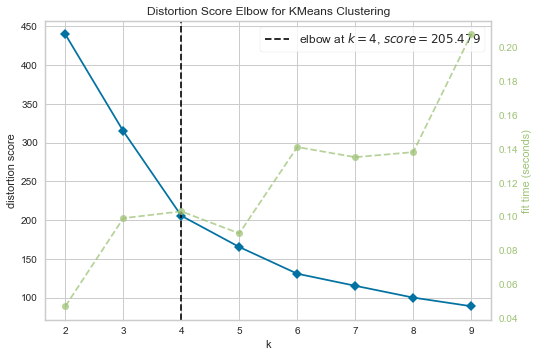

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [174]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)# Concentrating on creating 2 to 10 clusters
visualizer.fit(df_norm) # Fitting the normalized data to visualizer
visualizer.show()# Displaying the Elbow plot

the best number of cluster is 4, therefore we are going to input it into the kmeans model

In [175]:

# Fitting the model for 6 clusters as mentioned by the elbow method
kmean_model = KMeans(n_clusters = 4, random_state = 1)
kmeans_fit = kmean_model.fit_predict(df_norm)

3d visualization by reducing feature using PCA

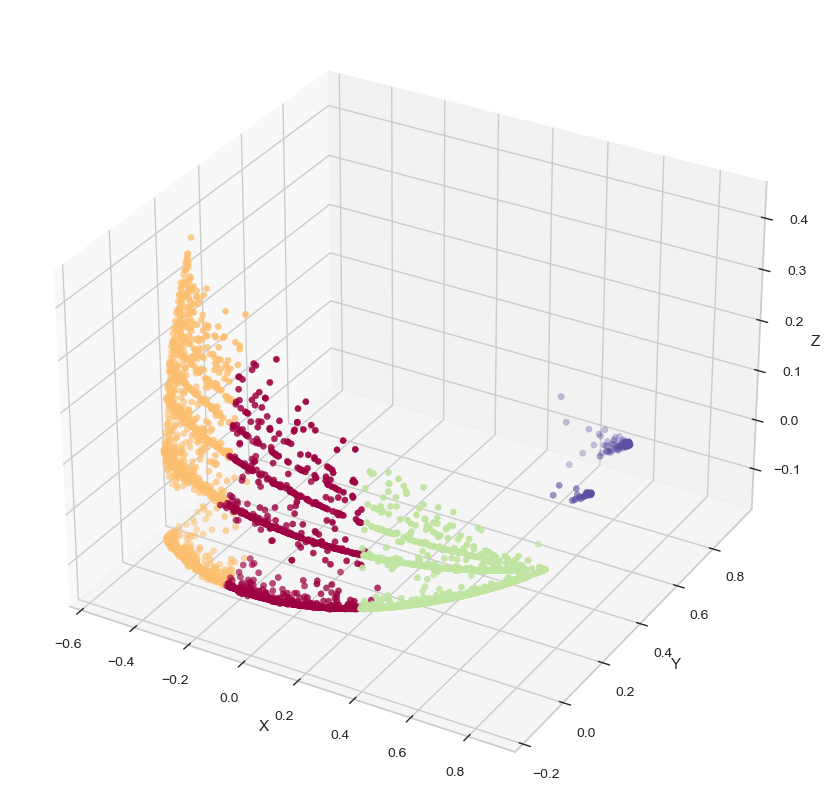

In [176]:
# Visualizing the clustered data by making used of PCA 
# As presented on article: https://medium.com/@mbektas/customer-segmentation-with-clustering-algorithms-in-python-be2e021035a

pca = PCA(n_components = 3).fit_transform(df_norm)
fig = plt.figure(figsize=(18.5, 10.5), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=kmeans_fit,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

mapping cluster into the original customer profile

In [177]:
# Mapping cluster number with user id by using original cust_profile df
cust_profile_drop['cluster'] = list(kmeans_fit)
cust_profile_drop.head()

,user_id,total_view,total_cart_add,total_purchases,total_sessions,total_spent,min_spent,max_spent,cust_retailer_age,days_since_last_activity,first_view_age,days_since_last_view,first_cart_age,days_since_last_cart,first_purchase_age,days_since_last_purchase,cluster
2,1515915625353534622,5.00,2.00,3.00,10.00,57.15,19.05,19.05,145,136,145.00,136.00,145.00,145.00,145.00,145.00,2
3,1515915625353561691,6.00,2.00,2.00,1.00,345.72,172.86,172.86,96,95,96.00,95.00,96.00,95.00,96.00,95.00,0
4,1515915625353900095,36.00,2.00,2.00,17.00,57.85,18.10,39.75,154,133,154.00,133.00,136.00,136.00,136.00,136.00,2
6,1515915625354561351,15.00,3.00,3.00,2.00,155.04,51.68,51.68,156,149,156.00,149.00,156.00,149.00,156.00,149.00,2
8,1515915625354857951,13.00,2.00,2.00,1.00,210.28,105.14,105.14,103,101,103.00,101.00,103.00,101.00,101.00,101.00,0


In [178]:
#### Analyzing customers in each all profile features kmeans clusters
customers=pd.DataFrame(cust_profile_drop['cluster'].value_counts()).rename(columns={'Clusters':'Number of Customers'})
customers.T

,1,2,0,3
cluster,2257,1264,1136,161


above are number of user that categorized and clustered into cluster 0,1,2, and 3

In [179]:
# Analyzing RFM behavior of each cluster 
# where R,F,M values are given by the columns - 'days_since_last_purchase','total_purchases','total_spent'
cust_profile_drop.groupby('cluster').agg(
{
    'days_since_last_purchase':['mean','min','max'],
    'total_purchases':['mean','min','max'],
    'total_spent':['mean','min','max']
})

days_since_last_purchase             total_purchases             \
                            mean  min    max            mean  min   max   
cluster                                                                   
0                          86.46 3.00 157.00            2.87 2.00 16.00   
1                          43.39 0.00 156.00            3.50 2.00 56.00   
2                         103.68 9.00 157.00            2.56 2.00 10.00   
3                          67.37 1.00 154.00            2.89 2.00 28.00   

        total_spent                 
               mean   min      max  
cluster                             
0            296.37  7.08   892.23  
1            925.52 21.58 12080.83  
2             89.68  2.47   287.66  
3            487.67 10.99  3939.88

now the summary of cluster are:
- cluster 2 are the least user that spend in the ecommerce and averaging the longest days since last purchase
- cluster 0 are the medium low customer 3rd tier of user spends in the ecommerce
- cluster 3 are the medium high costumer 2nd tier of user spends in the ecommerce 
- cluster 1 are the best user averaging most spend and most purchase of the all cluster and averaging shortest time between last purchase


In [180]:
cluster_segments = cust_profile_drop[['user_id','cluster']]
cluster_segments.head()

,user_id,cluster
2,1515915625353534622,2
3,1515915625353561691,0
4,1515915625353900095,2
6,1515915625354561351,2
8,1515915625354857951,0


now we are having the user id and their segmentation cluster

In [181]:
import pickle
with open('model/model_kmean_cluster.pkl','wb') as f:
    pickle.dump(kmean_model,f)

## Data Inference

trying the model into the data inference

In [182]:
df_inf

,total_view,total_cart_add,total_purchases,total_sessions,total_spent,min_spent,max_spent,cust_retailer_age,days_since_last_activity,first_view_age,days_since_last_view,first_cart_age,days_since_last_cart,first_purchase_age,days_since_last_purchase
5826,3.00,1.00,3.00,5.00,2017.89,672.63,672.63,83,83,83.00,83.00,83.00,83.00,83.00,83.00
2799,10.00,3.00,2.00,1.00,307.66,153.83,153.83,121,119,121.00,119.00,121.00,119.00,119.00,119.00
1195,32.00,1.00,3.00,18.00,296.94,98.98,98.98,141,136,141.00,136.00,141.00,141.00,141.00,141.00
8946,2.00,1.00,3.00,6.00,129.33,43.11,43.11,45,45,45.00,45.00,45.00,45.00,45.00,45.00
1635,11.00,2.00,3.00,1.00,214.56,71.52,71.52,135,129,135.00,129.00,130.00,129.00,130.00,129.00
4055,27.00,2.00,3.00,32.00,221.43,73.81,73.81,106,105,106.00,105.00,106.00,105.00,106.00,105.00
7673,2.00,1.00,3.00,2.00,220.95,73.65,73.65,60,60,60.00,60.00,60.00,60.00,60.00,60.00
10355,1.00,1.00,2.00,4.00,86.22,43.11,43.11,32,32,32.00,32.00,32.00,32.00,32.00,32.00
8128,17.00,3.00,3.00,1.00,1348.91,415.54,479.51,53,40,53.00,40.00,53.00,50.00,53.00,50.00
1734,1.00,1.00,2.00,4.00,227.62,113.81,113.81,133,133,133.00,133.00,133.00,133.00,133.00,133.00


scaling the data inference and then predict using model

In [183]:
df_inf.columns

Index(['total_view', 'total_cart_add', 'total_purchases', 'total_sessions',
       'total_spent', 'min_spent', 'max_spent', 'cust_retailer_age',
       'days_since_last_activity', 'first_view_age', 'days_since_last_view',
       'first_cart_age', 'days_since_last_cart', 'first_purchase_age',
       'days_since_last_purchase'],
      dtype='object')

In [184]:
inf_scaled = scaler.transform(df_inf)
inf_predict = kmean_model.predict(inf_scaled)

droping user id because we dont need it for machine learning input

In [185]:
inf_profile = cust_profile['user_id'].drop(index=cust_profile_drop.index)

predicting user id into their cluster prediction

In [186]:
inf_segments = pd.DataFrame()
inf_segments['user_id'] = inf_profile
inf_segments['cluster'] = inf_predict
inf_segments

,user_id,cluster
1195,1515915625524274739,1
1635,1515915625526774142,2
1734,1515915625527353999,2
2799,1515915625532384781,3
4055,1515915625539150431,2
5826,1515915625551812668,2
7673,1515915625571026773,3
8128,1515915625573454813,3
8946,1515915625592994743,1
10355,1515915625597806212,2


## Reference

- fuentes2750, Capstone EDA, Github.com, retrived from https://github.com/fuentes2750/capstone/tree/7422b0da80df3ea3948c010150e8bf14a9934cfe/EDA